# CAS Project

### Library imports

In [28]:
# Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import os
import random
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
import warnings

# tensor flow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image


# sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score


### Setup constants for directories

In [42]:
DIR_TRAIN = '/Users/alexchilton/Downloads/archive/train'
DIR_TEST = '/Users/alexchilton/Downloads/archive/test'
DIR_VALIDATION = '/Users/alexchilton/Downloads/archive/validation'
OUTPUT_DIR = '/Users/alexchilton/Downloads/working/'

DIR_REAL_TRAIN = '/Users/alexchilton/Downloads/working/train'
DIR_REAL_TEST = '/Users/alexchilton/Downloads/working/test'
DIR_REAL_VALIDATION = '/Users/alexchilton/Downloads/working/validation'

MODEL_LOCATION = '/Users/alexchilton/Downloads/working/best_model.keras'

### Helper fucntions



In [19]:
# Define a function to get the true label from the image path
def get_true_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Load and preprocess the images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize image to 128x128
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
    return img_array

def show_random_images(path = DIR_TRAIN, num_images=16):

    # Define the path to your test directory
    vis_dir = path

    # Get the list of all subdirectories (classes)
    classes = os.listdir(vis_dir)

    # Initialize an empty list to store file paths
    image_paths = []

    # Loop through each class folder and collect a few image paths
    for cls in classes:
        class_dir = os.path.join(vis_dir, cls)
        images = os.listdir(class_dir)
        for img in images:
            image_paths.append(os.path.join(class_dir, img))

    # Randomly select 16 images from the test set
    random_images = random.sample(image_paths, num_images)

    # Print the paths of the randomly selected images (for debugging only)
    #for img_path in random_images:
    #    print(img_path)


    # Set up a 4x4 grid for plotting
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    # Loop through the grid and add an image to each subplot
    for i, ax in enumerate(axes.flat):
        img = mpimg.imread(random_images[i])
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    # Display the plot
    plt.show()

def show_number_in_class(path = DIR_TRAIN, strType = 'Training', strColor = 'skyblue'):
    # Get the list of all subdirectories (classes)
    classes = os.listdir(path)

    # Count the number of images in each class
    image_count = {cls: len(os.listdir(os.path.join(path, cls))) for cls in classes}

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(image_count.keys(), image_count.values(), color=strColor)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class in the ' + strType + ' Data')
    plt.xticks(rotation=90, ha='right')  # Rotate class names for better readability
    plt.show()

def resize_and_save_image(input_path, output_path, size=(128, 128)):
    try:
        with Image.open(input_path) as img:
            # Handle images with Transparency in Palette mode
            if img.mode == 'P':
                img = img.convert('RGBA')
            # Convert image to RGB if it has an alpha channel or is Palette based
            if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
                img = img.convert('RGB')
            img = img.resize(size, Image.LANCZOS)
            img.save(output_path, format='JPEG')
    except Exception as e:
        print(f"Error processing {input_path}: {e}")

def process_directory(input_directory, output_directory):
    for root, dirs, files in os.walk(input_directory):
        # Create the corresponding directory structure in the output directory
        relative_path = os.path.relpath(root, input_directory)
        output_path = os.path.join(output_directory, relative_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        # Process each image file
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_file_path = os.path.join(root, file_name)
                output_file_path = os.path.join(output_path, file_name)
                resize_and_save_image(input_file_path, output_file_path)



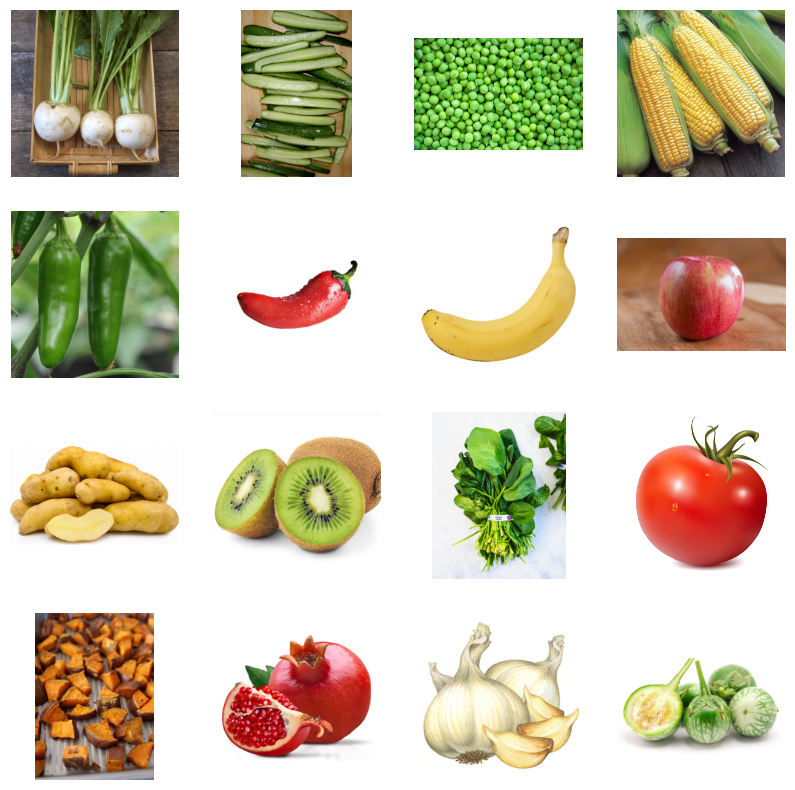

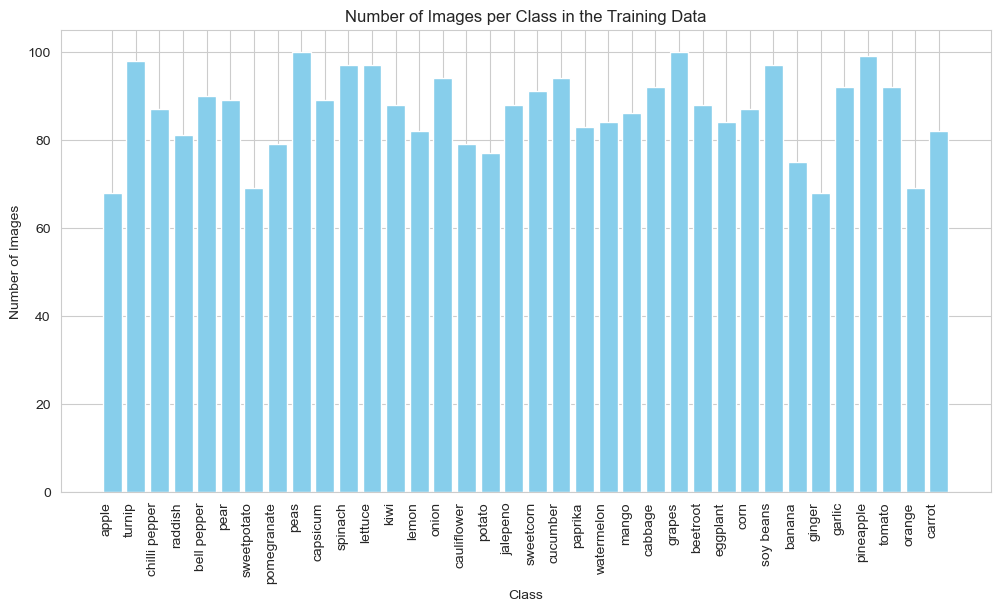

In [20]:
show_random_images(DIR_TRAIN, 16)
show_number_in_class(DIR_TRAIN, 'Training', 'skyblue')

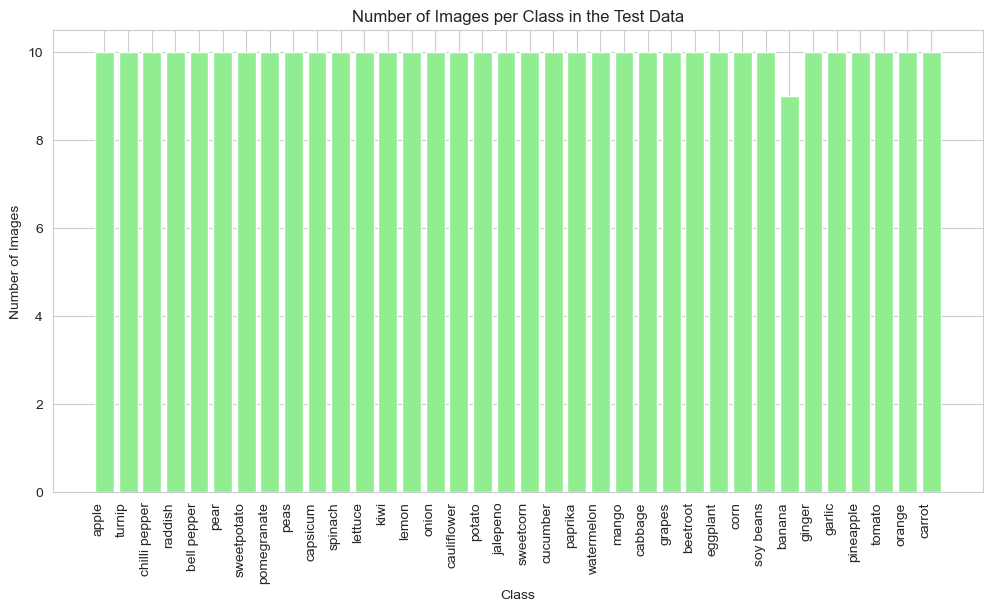

In [21]:
show_number_in_class(DIR_TEST, 'Test', 'lightgreen')

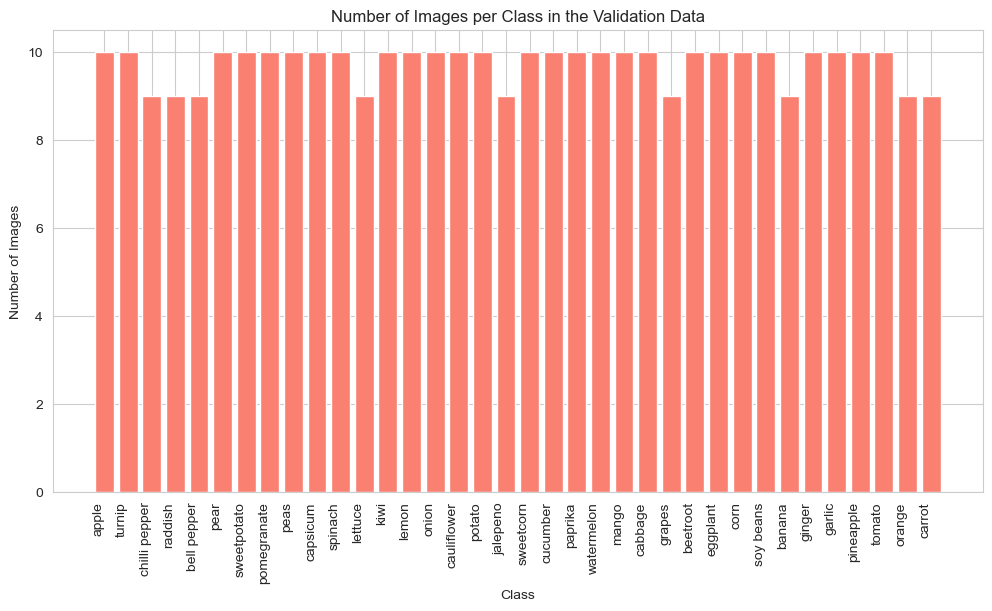

In [22]:
show_number_in_class(DIR_VALIDATION, 'Validation', 'salmon')

### Shrink images - only run once...

In [ ]:

# Define paths 
input_dirs = {
    'train': DIR_TRAIN,
    'validation': DIR_VALIDATION,
    'test': DIR_TEST
}
output_dir = OUTPUT_DIR

# Create output directory and subdirectories if they don't exist
for subset in input_dirs.keys():
    subset_dir = os.path.join(output_dir, subset)
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)


# Process each directory separately
for subset, dir_path in input_dirs.items():
    process_directory(dir_path, os.path.join(output_dir, subset))

print("Resizing and saving images completed.")


### Load shrunken images    

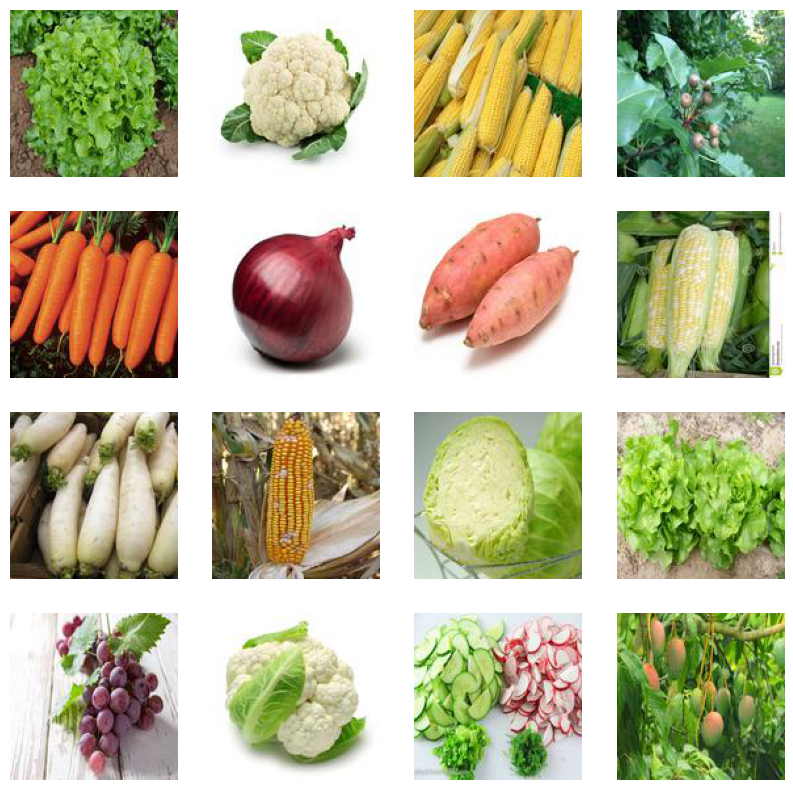

In [25]:
show_random_images(DIR_REAL_TRAIN,16)

### Data augmentation and preprocessing

In [27]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Define paths
train_dir = DIR_REAL_TRAIN
test_dir = DIR_REAL_TEST

# Create an instance of the ImageDataGenerator with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.1,
    #zoom_range=0.1,
    #horizontal_flip=True,
    #fill_mode='nearest'
)
# Create an instance of the ImageDataGenerator for the test set (usually without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    seed= 777,
    target_size=(128, 128),
    batch_size=20,           # Number of images to yield per batch
    class_mode='categorical' # Since we have multiple classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    seed= 777,
    target_size=(128, 128),
    batch_size=20,
    class_mode='categorical'
)

Found 3115 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


### Create a simple CNN model

In [29]:
# Create a more complex CNN model with padding adjustments
model = models.Sequential([
    # First convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Second convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Third convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),


    # Fourth convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fifth convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.2),


    # Flattening the 3D output to 1D
    layers.Flatten(),

    # Fully connected (Dense) layer
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    #layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Output layer with softmax activation for classification
    layers.Dense(36, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

2024-09-07 15:05:05.929095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-07 15:05:05.929265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                        

### Train the model

In [30]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    MODEL_LOCATION,  # Path where the model will be saved
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode to determine the best model ('max' for validation accuracy)
    verbose=1  # Verbosity mode
)

# Train the model
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=test_generator,
    verbose=2,
    callbacks=[checkpoint_callback]  # Include the callback
)

# Save the training history for later visualization
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


2024-09-07 15:08:25.755444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-07 15:08:27.270974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-07 15:08:27.456791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2024-09-07 15:09:01.278771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024


Epoch 1: val_accuracy improved from -inf to 0.05571, saving model to /Users/alexchilton/Downloads/working/best_model.keras
156/156 - 37s - loss: 3.2289 - accuracy: 0.1307 - val_loss: 4.1143 - val_accuracy: 0.0557 - 37s/epoch - 235ms/step


### Evaluate the model

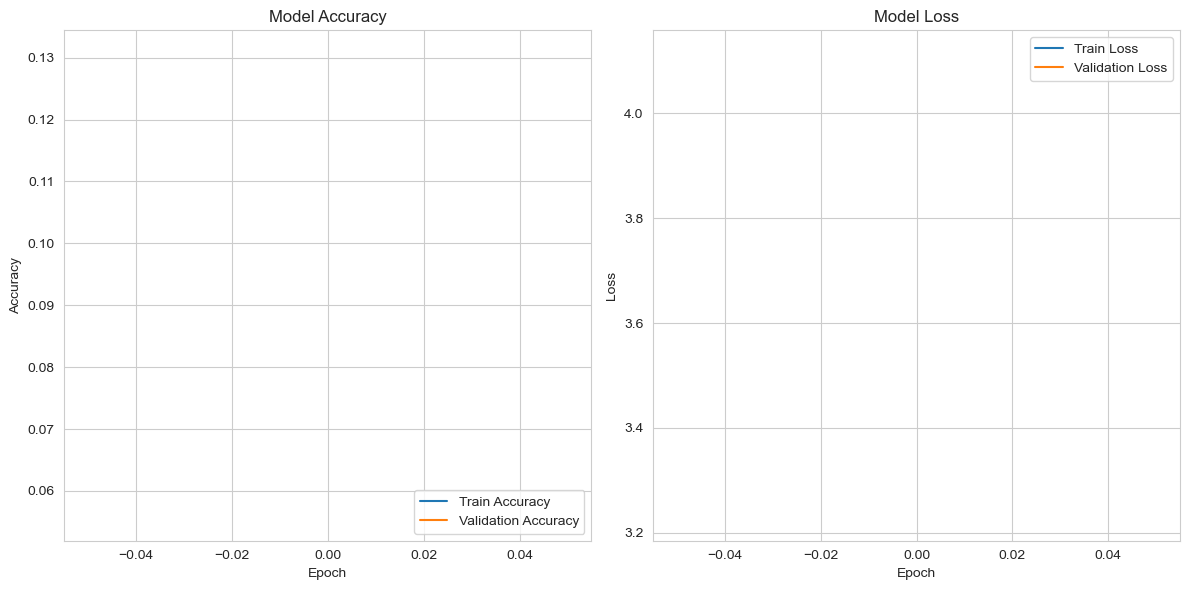

In [37]:
# Load the training history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()

### Predictions

In [38]:
# Initialize empty numpy arrays to store predicted classes and true labels
predictions = np.array([])
labels = np.array([])

# Reset the test generator to start from the first batch
test_generator.reset()

# Iterate through the test generator
for i in range(len(test_generator)):
    # Get the input data (x) and true labels (y)
    x, y = test_generator[i]

    # Use the model to predict the class probabilities of the input data
    predict_x = model.predict(x)

    # Convert the predicted probabilities to class predictions
    classes_x = np.argmax(predict_x, axis=1)

    # Add the predicted classes and true labels to the numpy arrays
    predictions = np.concatenate([predictions, classes_x])
    labels = np.concatenate([labels, np.argmax(y, axis=1)])  # Convert one-hot to class indices

# Convert the numerical labels to class names using the generator's class indices
label_names = {v: k for k, v in test_generator.class_indices.items()}

# Create a confusion matrix using the predicted classes and true labels
conf_matrix = confusion_matrix(labels, predictions, normalize='true')

1/1 [==============================] - 0s 23ms/step


### Confusion matrix


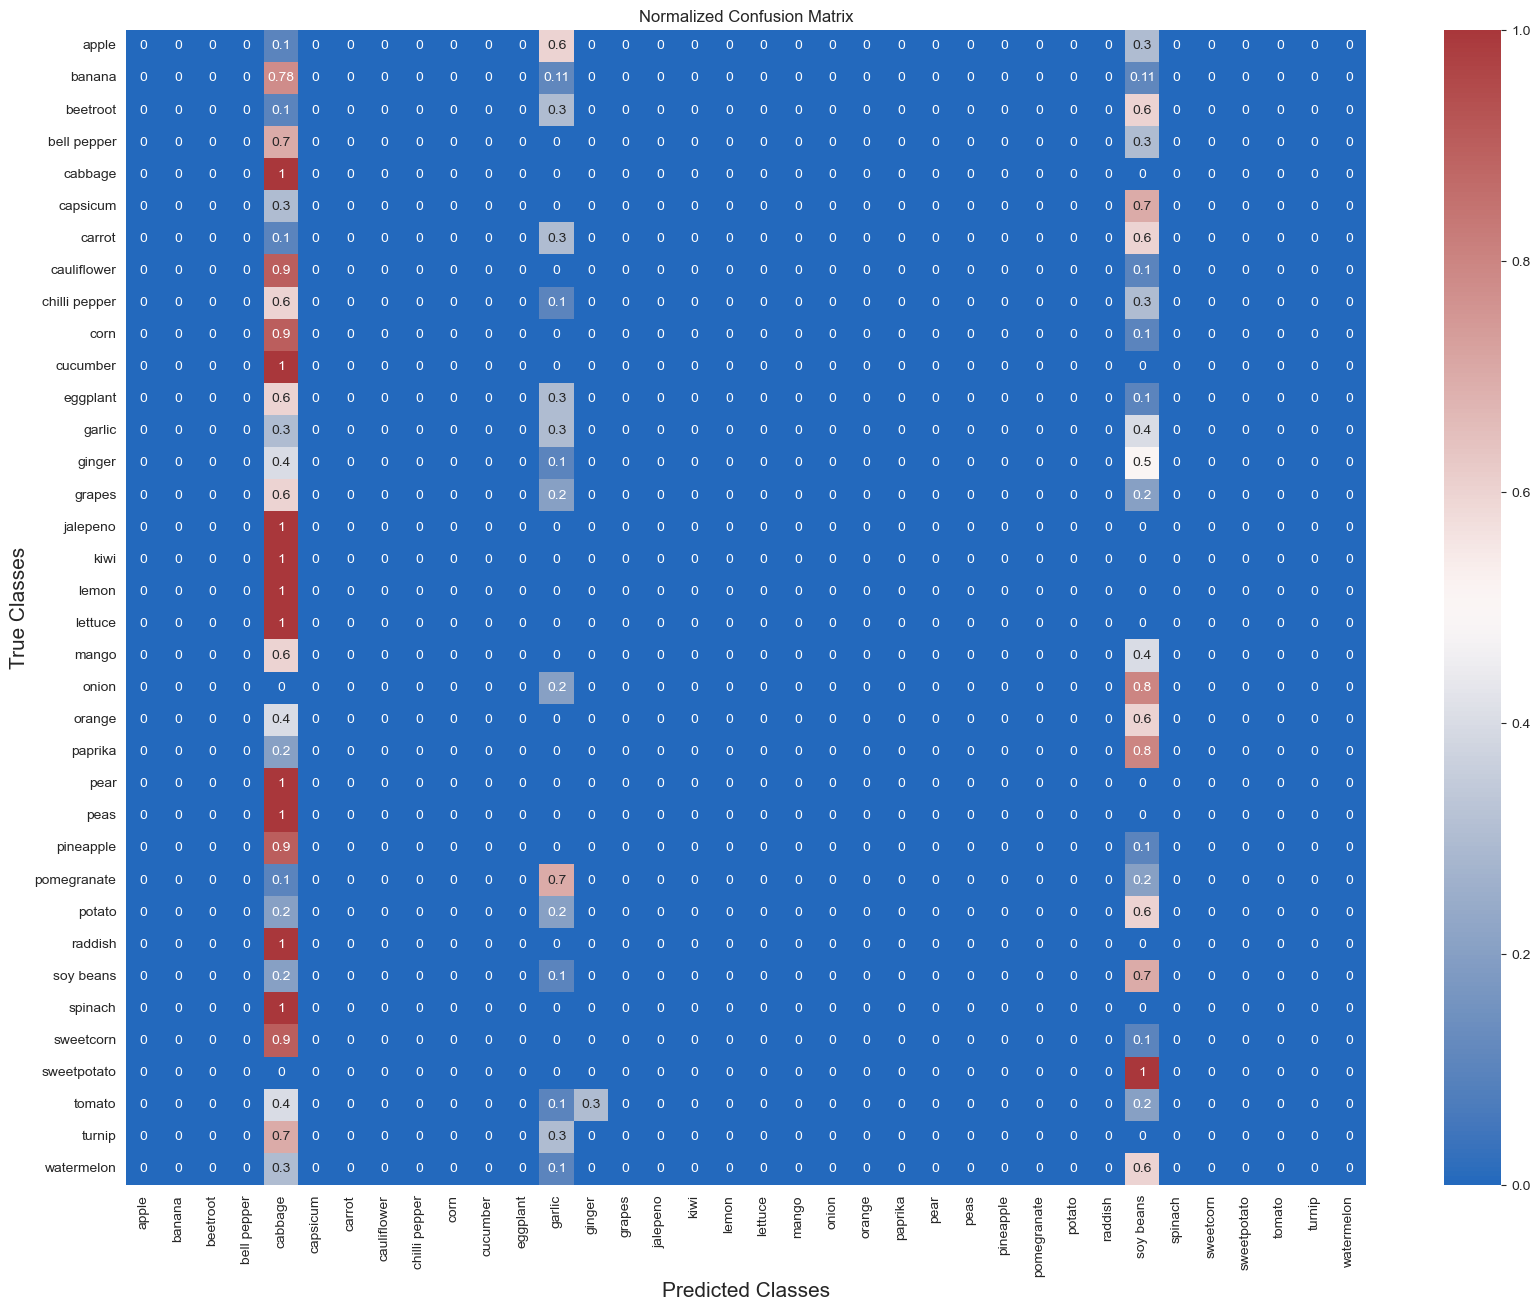

In [39]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix,
            cmap='vlag',
            annot=True,
            xticklabels=[label_names[x] for x in sorted(set(labels))],
            yticklabels=[label_names[x] for x in sorted(set(labels))])
plt.xlabel("Predicted Classes", fontsize=15)
plt.ylabel("True Classes", fontsize=15)
plt.title('Normalized Confusion Matrix')
plt.show()

### Classification report


In [40]:

# Convert numerical labels to class names using the generator's class indices
label_names = {v: k for k, v in test_generator.class_indices.items()}

# Generate classification report
class_report = classification_report(labels, predictions, target_names=[label_names[i] for i in sorted(label_names.keys())])

print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

        apple       0.00      0.00      0.00        10
       banana       0.00      0.00      0.00         9
     beetroot       0.00      0.00      0.00        10
  bell pepper       0.00      0.00      0.00        10
      cabbage       0.05      1.00      0.09        10
     capsicum       0.00      0.00      0.00        10
       carrot       0.00      0.00      0.00        10
  cauliflower       0.00      0.00      0.00        10
chilli pepper       0.00      0.00      0.00        10
         corn       0.00      0.00      0.00        10
     cucumber       0.00      0.00      0.00        10
     eggplant       0.00      0.00      0.00        10
       garlic       0.07      0.30      0.12        10
       ginger       0.00      0.00      0.00        10
       grapes       0.00      0.00      0.00        10
     jalepeno       0.00      0.00      0.00        10
         kiwi       0.00      0.00      0

In [41]:
# Load the trained model
model = tf.keras.models.load_model(MODEL_LOCATION)

# Define paths to the images
image_paths = [
    '/Users/alexchilton/Downloads/working/validation/apple/Image_1.jpg',
    '/Users/alexchilton/Downloads/working/validation/banana/Image_2.jpg',
    '/Users/alexchilton/Downloads/working/validation/orange/Image_3.jpg'
]

# Predict and get true labels
predictions = []
true_labels = []

for img_path in image_paths:
    img_array = load_and_preprocess_image(img_path)
    pred_prob = model.predict(img_array)
    pred_class = np.argmax(pred_prob, axis=1)[0]  # Get the predicted class index
    predictions.append(pred_class)
    true_labels.append(get_true_label(img_path))  # Extract true label from image path

# Convert numerical labels to class names using the generator's class indices
label_names = {v: k for k, v in test_generator.class_indices.items()}

print("Results:")
for i, img_path in enumerate(image_paths):
    pred_label = label_names[predictions[i]]
    true_label = true_labels[i]
    print(f"Image: {img_path}")
    print(f"Predicted Class: {pred_label}")
    print(f"True Class: {true_label}")
    print()

2024-09-07 15:16:35.355613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step
Results:
Image: /Users/alexchilton/Downloads/working/validation/apple/Image_1.jpg
Predicted Class: garlic
True Class: apple

Image: /Users/alexchilton/Downloads/working/validation/banana/Image_2.jpg
Predicted Class: soy beans
True Class: banana

Image: /Users/alexchilton/Downloads/working/validation/orange/Image_3.jpg
Predicted Class: soy beans
True Class: orange



In [43]:
# Load the trained model
model = tf.keras.models.load_model(MODEL_LOCATION)

# Define the paths to the validation set
val_dir = DIR_REAL_VALIDATION
# Create an ImageDataGenerator instance for the validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create the validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=20,
    class_mode='categorical',
    shuffle=False  # Do not shuffle to ensure correct mapping of predictions to true labels
)

# Predict the classes for the validation set
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the accuracy
print(f'Validation Accuracy: {accuracy:.4f}')

# Generate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


Found 351 images belonging to 36 classes.


2024-09-07 15:19:43.480215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-07 15:19:43.546989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 82ms/step
Validation Accuracy: 0.0570
Classification Report:
               precision    recall  f1-score   support

        apple       0.00      0.00      0.00        10
       banana       0.00      0.00      0.00         9
     beetroot       0.00      0.00      0.00        10
  bell pepper       0.00      0.00      0.00         9
      cabbage       0.05      1.00      0.09        10
     capsicum       0.00      0.00      0.00        10
       carrot       0.00      0.00      0.00         9
  cauliflower       0.00      0.00      0.00        10
chilli pepper       0.00      0.00      0.00         9
         corn       0.00      0.00      0.00        10
     cucumber       0.00      0.00      0.00        10
     eggplant       0.00      0.00      0.00        10
       garlic       0.07      0.30      0.12        10
       ginger       0.00      0.00      0.00        10
       grapes       0.00      0.00      0.00         9
     jalepeno 

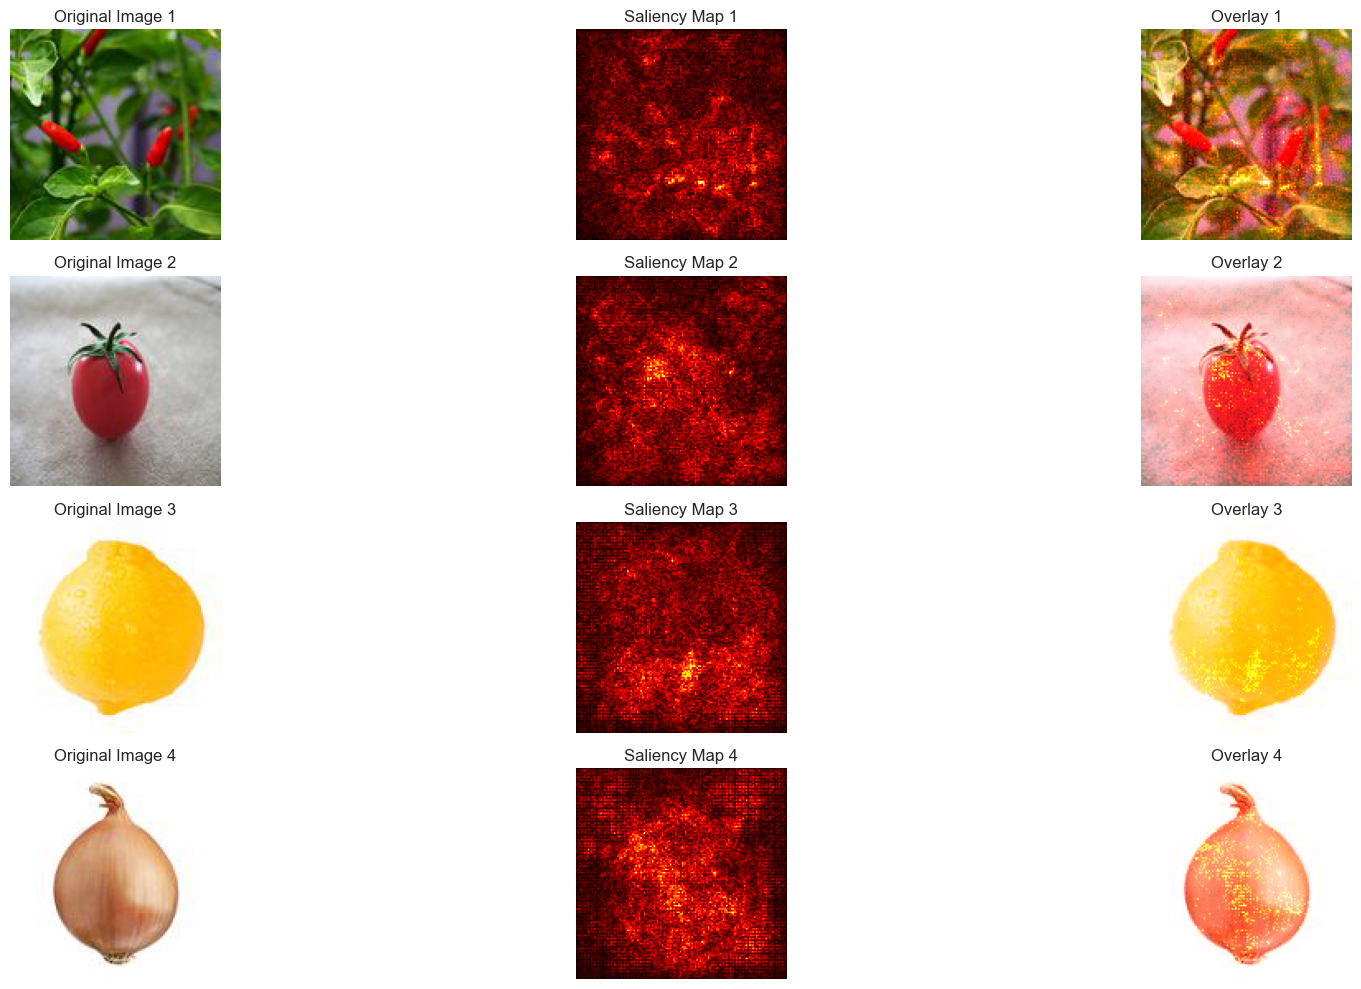

In [44]:
# Load the best model
model = tf.keras.models.load_model(MODEL_LOCATION)

# List of image paths
img_paths = [
    '/Users/alexchilton/Downloads/working/train/chilli pepper/Image_36.jpg',
    '/Users/alexchilton/Downloads/working/train/tomato/Image_9.jpg',
    '/Users/alexchilton/Downloads/working/train/lemon/Image_9.jpg',
    '/Users/alexchilton/Downloads/working/train/onion/Image_26.jpg'
]

# Function to preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale like in your generator
    return img_array

# Function to compute saliency map
def compute_saliency_map(model, img_array):
    img_array = tf.convert_to_tensor(img_array)  # Convert NumPy array to TensorFlow tensor
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        top_pred_idx = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_idx]

    # Get the gradient of the loss with respect to the input image
    grads = tape.gradient(top_class_channel, img_array)
    
    # Take the maximum of the gradients along the color channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    saliency = saliency.numpy()
    
    return saliency

# Function to overlay saliency map on the original image
def overlay_saliency_on_image(img_path, saliency_map):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0  # Normalize image array

    # Normalize saliency map
    saliency_map = np.interp(saliency_map[0], (saliency_map[0].min(), saliency_map[0].max()), (0, 1))
    
    # Create an overlay
    heatmap = cm.get_cmap('hot')(saliency_map)
    heatmap = heatmap[:, :, :3]  # Remove alpha channel
    overlay = np.clip(img_array + heatmap, 0, 1)
    
    return img_array, overlay

# Function to display images with overlays
def display_images_with_overlays(img_paths, saliency_maps):
    plt.figure(figsize=(20, 10))

    for i, (img_path, saliency_map) in enumerate(zip(img_paths, saliency_maps)):
        img_array, overlay = overlay_saliency_on_image(img_path, saliency_map)
        
        # Display original image
        plt.subplot(len(img_paths), 3, 3 * i + 1)
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(f'Original Image {i+1}')
        
        # Display saliency map
        plt.subplot(len(img_paths), 3, 3 * i + 2)
        plt.imshow(saliency_map[0], cmap='hot')
        plt.axis('off')
        plt.title(f'Saliency Map {i+1}')
        
        # Display image with saliency overlay
        plt.subplot(len(img_paths), 3, 3 * i + 3)
        plt.imshow(overlay)
        plt.axis('off')
        plt.title(f'Overlay {i+1}')

    plt.tight_layout()
    plt.show()

# Process and compute saliency maps for all images
saliency_maps = [compute_saliency_map(model, preprocess_image(img_path)) for img_path in img_paths]

# Display images with saliency overlays
display_images_with_overlays(img_paths, saliency_maps)
